In [114]:
import pandas as pd
import numpy as np
import pickle
import math
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,  mean_squared_error

In [115]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two PyTorch tensors of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number].values
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)

    # Convert lists of numpy arrays to single numpy arrays
    X_array = np.array(X, dtype=np.float32)
    y_array = np.array(y, dtype=np.float32).reshape(-1, 1)

    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.tensor(X_array)
    y_tensor = torch.tensor(y_array)

    return X_tensor, y_tensor

In [116]:
with open('grouped_datetime.pkl', 'rb') as file:
    cdr_data = pickle.load(file)
cdr_data.set_index('time_interval', inplace = True )
cdr_tensor = torch.tensor(cdr_data.values, dtype=torch.float32)
cdr_data.head(10)

,sms_in,sms_out,call_in,call_out,internet
time_interval,,,,,
2013-11-01 00:00:00,26734.588499,20239.160967,10006.074483,11472.884509,642388.341222
2013-11-01 00:10:00,22397.285624,18320.202647,8708.312181,10175.953187,630005.148721
2013-11-01 00:20:00,19697.901226,17062.049977,7917.187587,9230.907121,619933.182580
2013-11-01 00:30:00,18936.405777,15817.010519,7207.441154,8540.273192,590963.037909
2013-11-01 00:40:00,17443.714163,14147.854631,6575.749383,8068.724248,577130.081608
2013-11-01 00:50:00,16924.042149,14268.221651,6016.144075,7317.506059,563293.446691
2013-11-01 01:00:00,15544.169230,13761.794383,5675.190329,6930.658459,543777.683348
2013-11-01 01:10:00,14911.613535,13248.923135,4707.000540,5917.260537,532706.001709
2013-11-01 01:20:00,13827.671207,12276.710377,4574.100163,5657.404865,514802.046032


In [117]:
cdr_tensor[0]

tensor([ 26734.5879,  20239.1602,  10006.0742,  11472.8848, 642388.3125])

In [118]:
len(cdr_tensor)

8928

<Axes: xlabel='time_interval'>

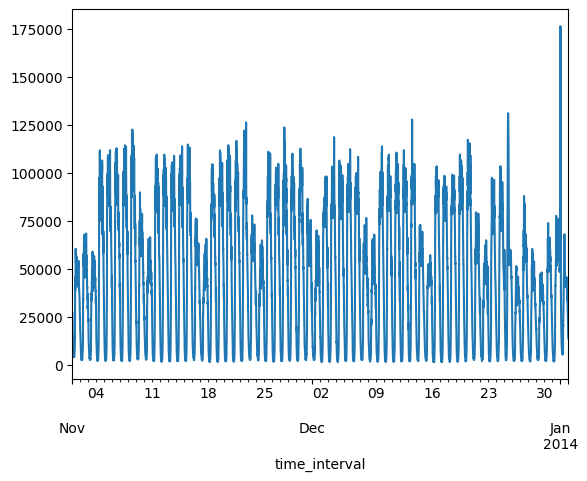

In [119]:
cdr_data['sms_in'].plot()

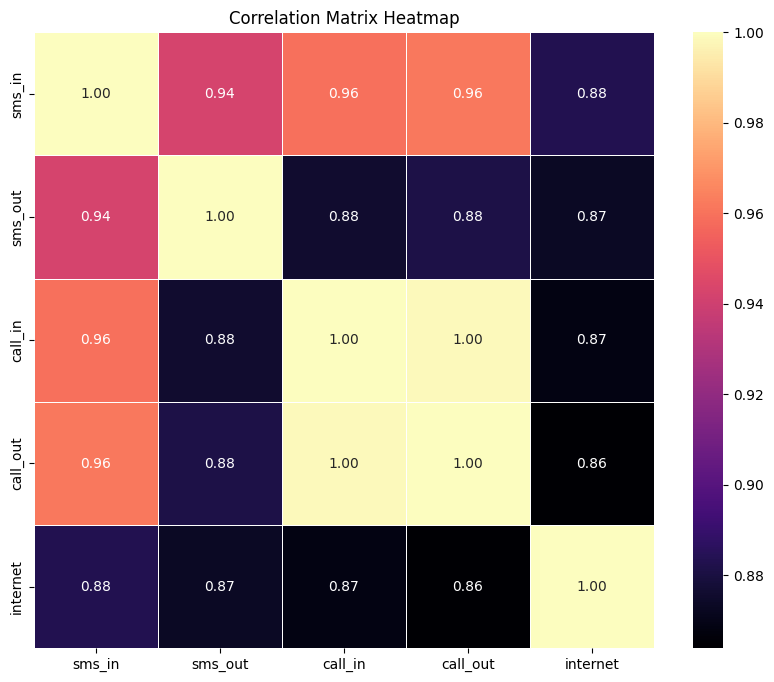

In [120]:
cdr_data_corr = cdr_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cdr_data_corr, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [121]:
window_size = 6  #1 hours

(X, y) = window_data(cdr_data, window_size, 4, 4)

In [122]:
print(X[0])

tensor([642388.3125, 630005.1250, 619933.1875, 590963.0625, 577130.0625,
        563293.4375])


In [123]:
print(y[0])

tensor([543777.6875])


In [124]:
X.shape

torch.Size([8921, 6])

In [125]:
y.shape

torch.Size([8921, 1])

In [126]:
"""extracts specific columns from the dataset to create new subsets of data"""
(sms_in, _) = window_data(cdr_data, window_size, 0, 1)
(sms_out, _) = window_data(cdr_data, window_size, 1, 1)
(call_in, _) = window_data(cdr_data, window_size, 2, 1)
(call_out, _) = window_data(cdr_data, window_size, 3, 1)
(internet, _) = window_data(cdr_data, window_size, 4, 1)

In [127]:
sms_in[0]

tensor([26734.5879, 22397.2852, 19697.9004, 18936.4062, 17443.7148, 16924.0430])

In [128]:
call_in[0]

tensor([10006.0742,  8708.3125,  7917.1875,  7207.4409,  6575.7495,  6016.1440])

In [129]:
sms_out[0]

tensor([20239.1602, 18320.2031, 17062.0508, 15817.0107, 14147.8545, 14268.2217])

In [130]:
call_out[0]

tensor([11472.8848, 10175.9531,  9230.9072,  8540.2734,  8068.7241,  7317.5059])

In [131]:
def standard_scale(tensor):
    mean = torch.mean(tensor, 0, keepdim=True)
    std = torch.std(tensor, 0, unbiased=False, keepdim=True)
    return (tensor - mean) / std

X = standard_scale(X)
sms_in = standard_scale(sms_in)
sms_out = standard_scale(sms_out)
call_in = standard_scale(call_in)
call_out = standard_scale(call_out)
internet = standard_scale(internet)

In [132]:
X_scaled, X_mean, X_std = standard_scale(X)
sms_in_scaled, sms_in_mean, sms_in_std = standard_scale(sms_in)
sms_out_scaled, sms_out_mean, sms_out_std = standard_scale(sms_out)
call_in_scaled, call_in_mean, call_in_std = standard_scale(call_in)
call_out_scaled, call_out_mean, call_out_std = standard_scale(call_out)
internet_scaled, internet_mean,internet_std = standard_scale(internet)


ValueError: ignored

In [133]:
X[0]

tensor([ 0.0906,  0.0353, -0.0097, -0.1393, -0.2011, -0.2629])

In [134]:
split = int(0.8 * len(X))

# Splitting data into training and test sets
X_train = X[:split - 1]
X_test = X[split:]

internet_train = internet[:split - 1]
internet_test = internet[split:]

y_train = y[:split - 1]
y_test = y[split:]

sms_in_train = sms_in[:split - 1]
sms_out_train = sms_out[:split - 1]
call_in_train = call_in[:split - 1]
call_out_train = call_out[:split - 1]

sms_in_test = sms_in[split:]
sms_out_test = sms_out[split:]
call_in_test = call_in[split:]
call_out_test = call_out[split:]

# Reshaping tensors for PyTorch (batch, seq_len, features)
X_train = X_train.unsqueeze(-1)
sms_in_train = sms_in_train.unsqueeze(-1)
sms_out_train = sms_out_train.unsqueeze(-1)
call_in_train = call_in_train.unsqueeze(-1)
call_out_train = call_out_train.unsqueeze(-1)
internet_train = internet_train.unsqueeze(-1)

# Concatenating training data
data_train = torch.cat((sms_in_train, sms_out_train, call_in_train, call_out_train, internet_train), dim=2)

X_test = X_test.unsqueeze(-1)
sms_in_test = sms_in_test.unsqueeze(-1)
sms_out_test = sms_out_test.unsqueeze(-1)
call_in_test = call_in_test.unsqueeze(-1)
call_out_test = call_out_test.unsqueeze(-1)
internet_test = internet_test.unsqueeze(-1)

# Concatenating test data
data_test = torch.cat((sms_in_test, sms_out_test, call_in_test, call_out_test, internet_test), dim=2)

In [21]:
X_train.shape
# This will print a shape like (batch_size, seq_len, n_features)

torch.Size([7135, 6, 1])

In [22]:
y_train.shape

torch.Size([7135, 1])

In [23]:
data_train.shape

torch.Size([7135, 6, 5])

In [24]:
"""Reshaping the data_train which is a 3 dimensional tensor"""
data_train_2d = data_train.reshape(data_train.size(0), -1)

In [25]:
"""Using elbow-method to find the suitable number of clusters"""
from sklearn.cluster import KMeans
SS = []
for i in range(2,20):
    model = KMeans(n_clusters=i,random_state=40)
    model.fit(data_train_2d)
    #Attribute inertia_ gives sum of squared distances of samples to their closest cluster center
    SS.append(model.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

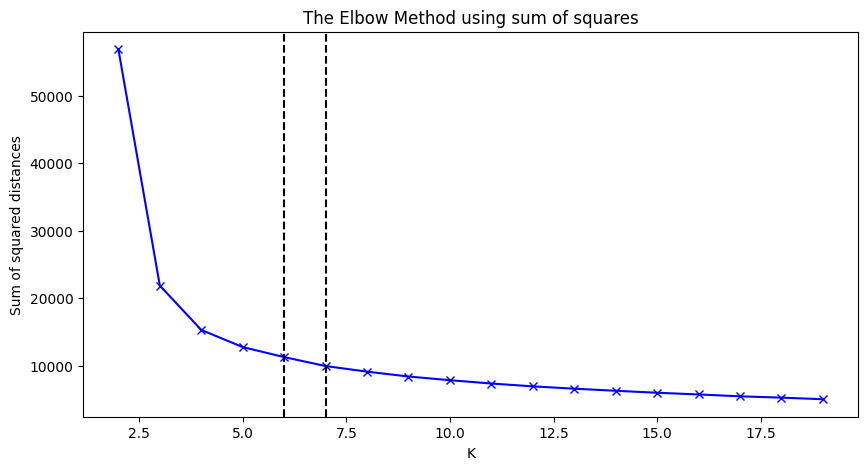

In [26]:
K = [i for i in range(2,20)]
plt.figure(figsize=(10,5))
plt.plot(K, SS, 'bx-')
plt.axvline(6, color='black', ls='dashed')
plt.axvline(7, color='black', ls='dashed')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.title('The Elbow Method using sum of squares')
plt.show()

# *Note about Elbow method*
From the Elbow Method, notice that we have a very smooth elbow. Curve plateaus after K=6 or K=7

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.46156937


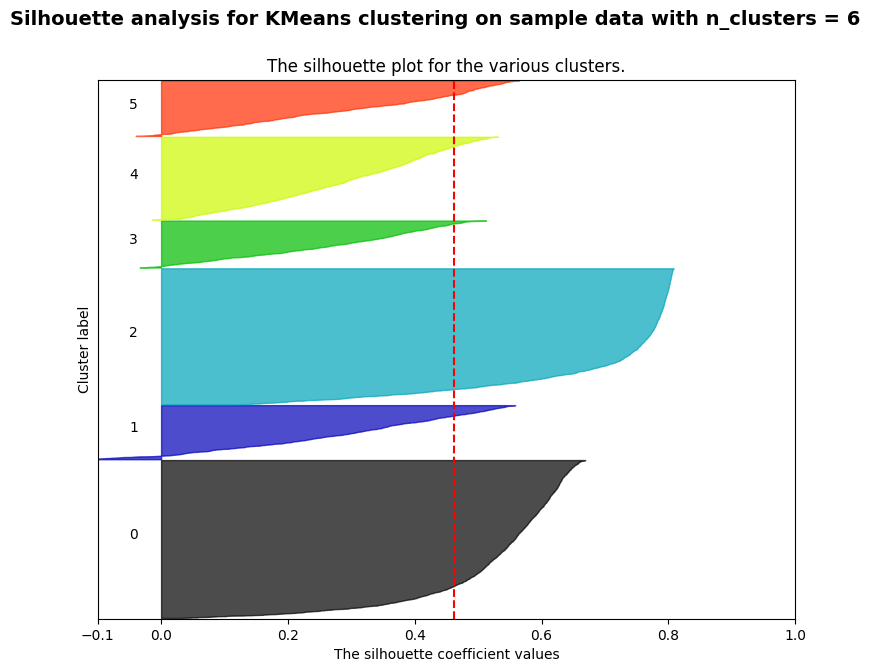

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.3832


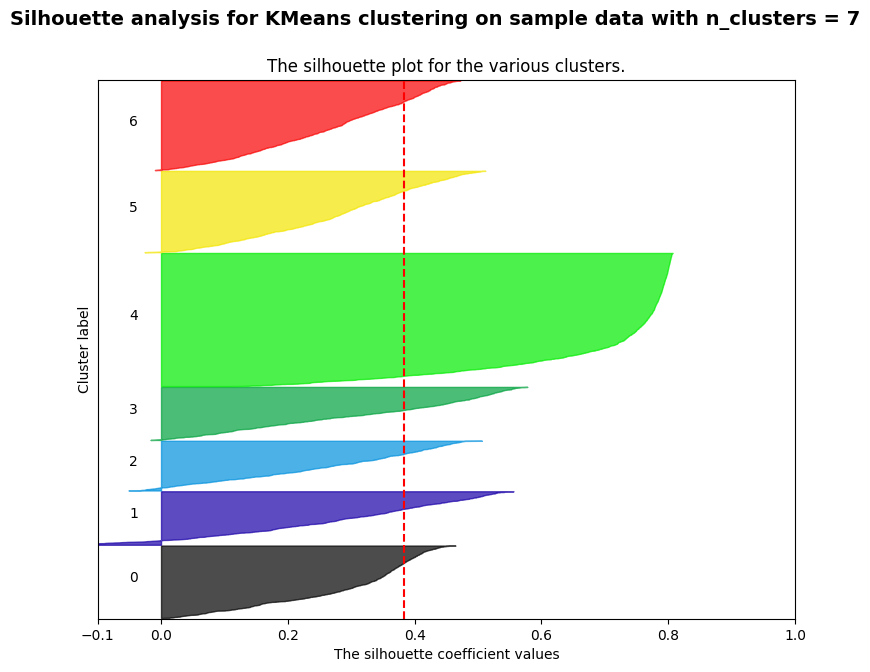

In [27]:
#Using Silhouette coefficient on various values of K
#Code is sourced from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = range(6,8)
avg_silhouette_score=[]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_train_2d) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data_train_2d)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_train_2d, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    #avg_silhouette_score will be used in next cell to plot against K
    avg_silhouette_score.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_train_2d, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

# From Silhouette coefficient and Elbow Method we can conclude that the optimal value would be K=6.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


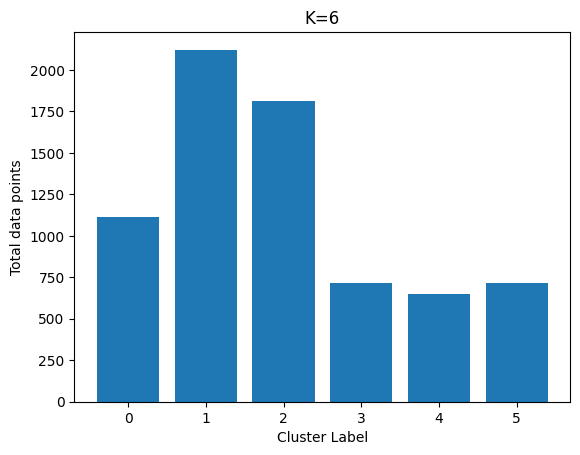

In [28]:
"""Fitting the model with K=6 and display the distribution of grids in each subgroup"""
model = KMeans(n_clusters=6,random_state=40)
model.fit(data_train_2d)
labels = model.labels_
unique, counts = np.unique(labels, return_counts=True)
plt.bar(range(0,6), counts)
plt.xlabel('Cluster Label')
plt.ylabel('Total data points')
plt.title('K=6')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


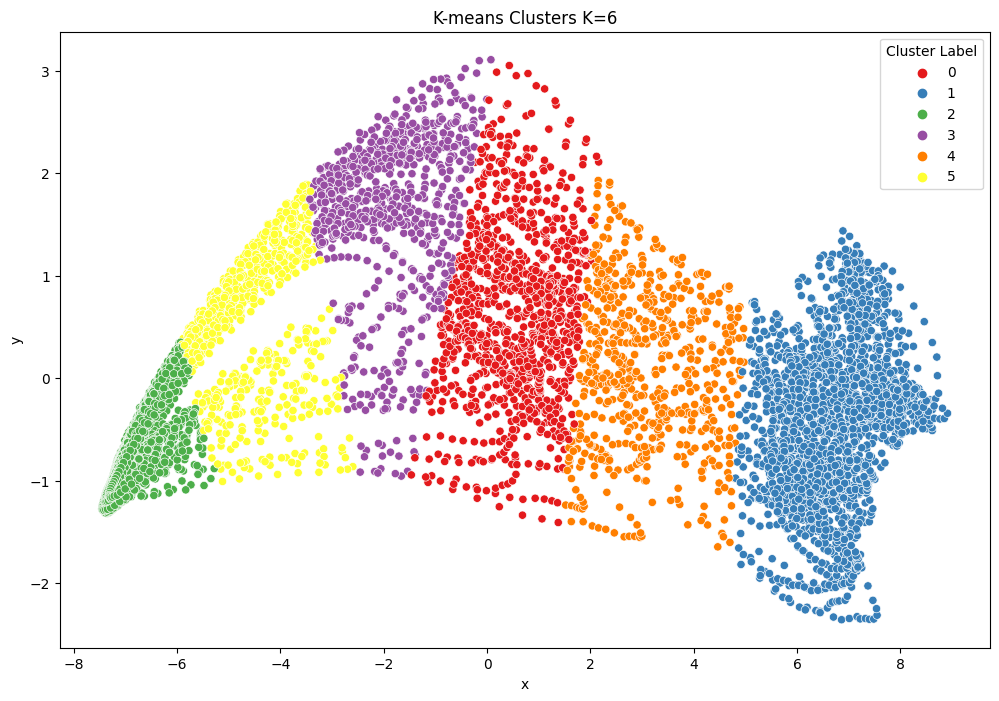

In [29]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming data_train is your input data and is a PyTorch tensor
# Reshape data_train to 2D and convert it to a NumPy array
data_train_2d = data_train.reshape(data_train.size(0), -1).numpy()

# KMeans clustering with K=6
model = KMeans(n_clusters=6, random_state=40)
model.fit(data_train_2d)
labels = model.labels_

# PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
data_train_2d_pca = pca.fit_transform(data_train_2d)

# Create a DataFrame with the PCA components and the cluster labels
df = pd.DataFrame(data_train_2d_pca, columns=['x', 'y'])
df['Cluster Label'] = labels

# Plot a scatterplot of the 'x' vs 'y' columns
# Color-code points differently based on cluster ID
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', data=df, hue='Cluster Label', palette='Set1').set_title('K-means Clusters K=6')
plt.show()


In [30]:
"""Number of grids in each cluster"""
ClusterResult = df.groupby('Cluster Label')['Cluster Label'].count()
ClusterResult = ClusterResult.to_frame()
ClusterResult.columns = ['Number of Grids']
ClusterResult

,Number of Grids
Cluster Label,
0,1115
1,2122
2,1813
3,717
4,652
5,716


In [33]:
"""Get the gridID from each cluster for display"""
# Extract the indices (or row numbers) for each cluster

cluster_indices = {}
for cluster_label in range(6):  # Assuming you have 6 clusters labeled from 0 to 5
    cluster_indices[cluster_label] = df[df['Cluster Label'] == cluster_label].index.tolist()

cluster0Indices = cluster_indices[0]
cluster1Indices = cluster_indices[1]
cluster2Indices = cluster_indices[2]
cluster3Indices = cluster_indices[3]
cluster4Indices = cluster_indices[4]
cluster5Indices = cluster_indices[5]



In [39]:
import geopandas
import pandas as pd

# Load the GeoJSON file
milan = geopandas.read_file('/content/milano-grid.geojson')

# Assign colors and attributes to each cluster
cluster_colors = ["#6ACC64", "#EE854A", "#8C613C", "#FFFF33", "#D65F5F", "#D5BB67"]
cluster_files = ["grid0json.geojson", "grid1json.geojson", "grid2json.geojson",
                 "grid3json.geojson", "grid4json.geojson", "grid5json.geojson"]

for i in range(6):
    # Get the indices for the current cluster
    cluster_indices = df[df['Cluster Label'] == i].index.tolist()

    # Filter the GeoDataFrame for the current cluster
    displayGrid = milan.loc[milan.index.isin(cluster_indices)]
    displayGrid['fill'] = cluster_colors[i]
    displayGrid['stroke-width'] = 0
    displayGrid['fill-opacity'] = 0.7 if i != 0 and i != 3 else 0.5  # Adjust opacity based on original settings

    # Convert to GeoJSON
    displayGrid_json = displayGrid.to_json()

    # Save to a file
    with open(cluster_files[i], "w") as file:
        file.write(displayGrid_json)

# For clusters with more than 1895 grids, they are saved to files and can be opened in a browser


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [45]:
import folium
import json

# Correct path to the GeoJSON file
geojson_path = '/content/grid1json.geojson'
with open(geojson_path, 'r') as file:
    geojson_data = json.load(file)

# Assuming the map center is Milan
map_center = [45.4642, 9.1900]

# Create a Folium map at the center location
map_milan = folium.Map(location=map_center, zoom_start=12)

# Add the GeoJSON data to the map
folium.GeoJson(
    geojson_data,
    name='geojson'
).add_to(map_milan)

# Display the map
map_milan



Now to perform forecasting based on clusters we can take an Neural Network or Deep Learning Model such as ARIMA or LSTM.

In [46]:
"""Using Yilei's Basic LSTM"""

"Using Yilei's Basic LSTM"

In [136]:
class BasicLSTM(nn.Module):
    def __init__(self, window_size=6, n_features=1):
        super(BasicLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=n_features, hidden_size=100, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(100 * window_size, 1500)
        self.fc2 = nn.Linear(1500, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the BasicLSTM model
window_size = 6
n_features = X_train.shape[2]

In [137]:
ls_model = BasicLSTM(window_size=window_size, n_features=n_features)

In [138]:
print(ls_model)

BasicLSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=600, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


# Initializing Models for Each Cluster

In [140]:
clustered_models = {}
for cluster_label in range(6):  # For 6 clusters
    model = BasicLSTM(window_size=window_size, n_features=n_features)
    clustered_models[cluster_label] = model

In [141]:
"""Segmenting original training data based on cluster labels"""
X_train_clustered = {}
y_train_clustered = {}

for cluster_label in range(6):  # Assuming 6 clusters
    cluster_indices = (labels == cluster_label)

    X_train_clustered[cluster_label] = X_train[cluster_indices]
    y_train_clustered[cluster_label] = y_train[cluster_indices]


In [142]:
lstm_loss = {}
epochs = 10
batch_size = 100

for cluster_label in clustered_models:
    model = clustered_models[cluster_label]
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    cluster_loss = []


    X_train = X_train_clustered[cluster_label]
    y_train = y_train_clustered[cluster_label]

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            optimizer.zero_grad()  # Clear gradients
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters

            total_loss += loss.item()

        avg_loss = total_loss / len(X_train)
        cluster_loss.append(avg_loss)

    lstm_loss[cluster_label] = cluster_loss
    print(f'Cluster {cluster_label}: Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Cluster 0: Epoch 10/10, Loss: 4093885597.0439
Cluster 1: Epoch 10/10, Loss: 845443887.5325
Cluster 2: Epoch 10/10, Loss: 126365528.5339
Cluster 3: Epoch 10/10, Loss: 4597626757.1771
Cluster 4: Epoch 10/10, Loss: 6456744074.2086
Cluster 5: Epoch 10/10, Loss: 2901920213.0950


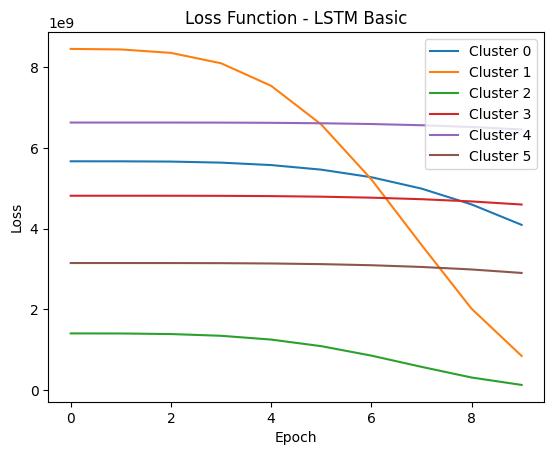

In [143]:

# Assuming lstm_loss is a dictionary with cluster labels as keys and lists of loss values as values
for cluster_label, losses in lstm_loss.items():
    plt.plot(losses, label=f'Cluster {cluster_label}')

plt.title("Loss Function - LSTM Basic")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [144]:
ls_model.eval()

BasicLSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=600, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)